# Cifar10 classification case study with novel class
Goal: In this notebook you will investigate which advantages Bayesian NNs can offer in a classification task. You will use train data from 9 of the 10 classes in the Cifar10 dataset to fit different three probabilistic NN. First you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via variational inference and one via dropout. You will compare the accuracy of the different NN on the 9 known classes. Further you will investigate and compare the uncertainties expressed by the NNs for both the known classes and unknown class. Finally you will use these uncertainties to detect novel classes and filter out uncertain predictions.

Usage: The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

Dataset: You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"). You will delete all images from the class "horse" in the training dataset to simulate a novel class. Note that we keep the class "horse" in the test dataset.

Content:

Load the Cifar10 dataset
Delete all images of the class "horse" from the training dataset
Split the train dataset into a train and validation dataset (60:40 split)
Fit a non-Bayesian NN
Fit a Bayesian NN via variational inference
Fit a Bayesian NN via dropout
Compare the of the accuracy of the models on the known classes
Compare the of the uncertainties of the models on the known and unknown classes
Use the uncertainties to filter uncertain predictions

**HINT**: This notebook is a modified copy of [tensorchiefs/dl_book](https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_04.ipynb) to compare MP against MC and a Non-Bayesian approach for novel class

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
# Need to be added before import of tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
sys.path.append("../")
import src.mp.MomentPropagation as mp
import numpy as np
import pandas as pd
import urllib.request
import time
from tqdm.notebook import tqdm as tqdm
%matplotlib inline
plt.style.use('default')

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tfk = tf.keras

1 Physical GPUs, 1 Logical GPUs


In [2]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.cifar10.load_data()

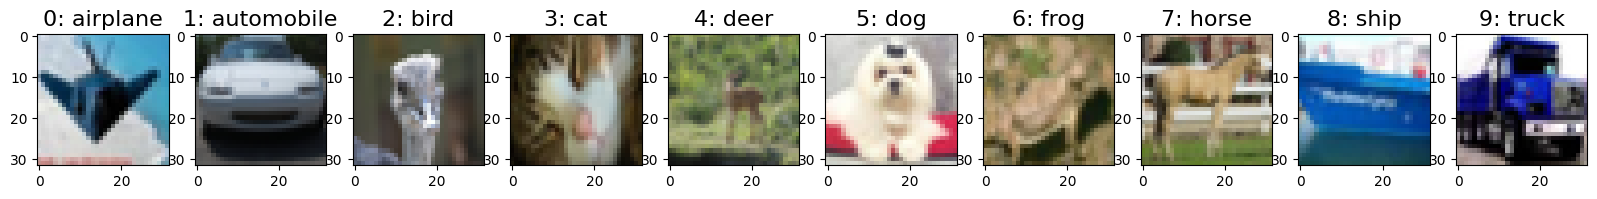

In [3]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)

To simualte a novel class, you will delete all images of the class "horse" from the traning dataset. Note that you do this only in the trainset, the test dataset stays the same. In the train dataset you will now have 9 classes with 5'000 images of every class, in total 45'000 images. This will be your traning dataset for the three models.

In [4]:
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])
print(y_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)
(45000, 9)


Now you split the new training dataset without the horses randomly into a train and validationset. You use a 60:40 ratio for the split, so you have 27'000 train images with 9 classes and 18'000 validation images with 9 classes. The test dataset has 10'000 images and 10 classes. Note that we have a novel (unknown) class "horse" in the testset.

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

#Before training the NNs with the data, we normalize the data to be in the range between -1 and 1. 
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

x_test.min(), x_test.max()

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


(-1.0, 1.0)

# Create the model
Now we will use the same model as provided by [Tensorchiefs MC Dropout](https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_04.ipynb) `USE_TC=True` and another model with different layer structure. Just inspect how the predictions behave and e.g. what happens if you only use dropout in the front part of the network and/or in the back part (on Dense only).

In [6]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Sequential

tfk.backend.clear_session()
USE_BN = True  # True if use BatchNormalization
USE_TC = True  # True if Tensorchiefs MC dropout model

if USE_TC:
    model = Sequential()
    model.add(Convolution2D(8, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(32, 32, 3)))
    if USE_BN:
        model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Convolution2D(8, kernel_size=(3, 3), padding="same", activation='relu'))
    if USE_BN:
        model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))

    model.add(Convolution2D(16, kernel_size=(3, 3), padding="same", activation='relu'))
    if USE_BN:
        model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Convolution2D(16, kernel_size=(3, 3), padding="same", activation='relu'))
    if USE_BN:
        model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(9, activation='softmax'))

else:

    model = Sequential()
    model.add(Convolution2D(16, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(32, 32, 3)))
    if USE_BN:
        model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Convolution2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
    if USE_BN:
        model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Convolution2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    if USE_BN:
        model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(9, activation='softmax'))

''' Compile the model using categorical crossentropy loss and adam optimizer with default params'''
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0

# Train the model
Here we can either train the model or load the weights (tensorchiefs)

In [7]:
n_epochs = 50
fname = f"weights/model_cifar10_weights_{n_epochs}_TC={USE_TC}_BN={USE_BN}.hdf5"
history = None
if not os.path.isfile(fname):
    history = model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=512,epochs=n_epochs,verbose=1)
    model.save_weights(fname)
else:
    # download and load weights of the model
#     urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc_cifar10_weights.hdf5", f"weights/model_mc_cifar10_weights.hdf5")
#     fname = "weights/model_mc_cifar10_weights.hdf5"
    print(f"Loading weights {fname}")
    model.load_weights(fname)

Loading weights weights/model_cifar10_weights_50_TC=True_BN=True.hdf5


In [8]:
if history is not None:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim(0, 1)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='lower right')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper right')

In [9]:
known_idx=np.where(y_test!=7)[0]
unknown_idx=np.where(y_test==7)[0]
print(len(known_idx))
print(len(unknown_idx))

9000
1000


# Prediction

## Non-Bayesian prediction
Here you predict the lables for the non-bayesian CNN and calculate the uncertainty measures. You calculate the nll and the entropy, note that there is no total standart deviation in the non-bayesian model, because the same image will always get the same prediction. This is also the reason why we don't need to predict the same image for multiple times.

In [10]:
start = time.time()
pred=model.predict(x_test)
rt = time.time() - start
pred_max_p=np.max(pred,axis=1)
entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
nll_=-np.log(pred_max_p)
pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])

In [11]:
test_acc_all=np.average(true_labels==pred_labels)
test_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])
test_acc_all, test_acc_known

(0.5841, 0.649)

## Bayesian MC prediction
Here you predict the lables for the bayesian CNN via dropout and calculate the uncertainty measures. You predict the same image for 50 times and calculate the mean predicted probabilities, the nll, the entropy and total standart deviation.

In [12]:
pred_mc=np.zeros((len(x_test),9))
pred_max_p_mc=np.zeros((len(x_test)))
pred_std_mc=np.zeros((len(x_test)))
entropy_mc = np.zeros((len(x_test)))
rt_mc = 0

if USE_BN:
    ''' If we use BN we have to disable BN during forwardpass for MC dropout'''
    for l in model.layers:
        if l.__class__.__name__ == "BatchNormalization":
            print(l.__class__.__name__,l.trainable)
            l.trainable = False
        

for i in tqdm(range(0,len(x_test))):
    multi_img=np.tile(x_test[i],(50,1,1,1))
    start = time.time()
    preds=model([multi_img], training=True) # Enable Dropout during forward-pass
    rt_mc += time.time() - start
    pred_mc[i]= np.mean(preds,axis=0)
    pred_max_p_mc[i]=np.argmax(np.mean(preds,axis=1))#mean over n runs of every proba class
    pred_std_mc[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
    entropy_mc[i] = -np.sum( pred_mc[i] * np.log2(pred_mc[i] + 1E-14)) #Numerical Stability


pred_labels_mc=np.array([labels_no_horse[np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])
pred_mc_mean_max_p=np.array([pred_mc[i][np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])
nll_mc=-np.log(pred_mc_mean_max_p)

BatchNormalization True
BatchNormalization True
BatchNormalization True
BatchNormalization True


In [13]:
test_acc_all_mc=np.average(true_labels==pred_labels_mc)
test_acc_known_mc=np.average(true_labels[known_idx]==pred_labels_mc[known_idx])
test_acc_all_mc, test_acc_known_mc

(0.6258, 0.6953333333333334)

## Bayesian MP prediction
Now we want to predict the labesl for the single-shot moment propagation using the same model but without enabling dropout during the single forward pass. We calculate the predicted probabilities by propagating the first two moments through the network assuming gaussian distribution.

In [14]:
# Create a Moment Propagation Model from a given model
model_mp = mp.MP()
model_mp.create_MP_Model(model=model, use_mp=True, verbose=False)

pred_mp=np.zeros((len(x_test),9))
pred_max_p_mp=np.zeros((len(x_test)))
pred_std_mp=np.zeros((len(x_test)))
entropy_mp = np.zeros((len(x_test)))

start = time.time()
pred_mp,var_mp=model_mp.model.predict(x=x_test)
rt_mp = time.time() - start
pred_max_p_mp=np.max(pred_mp,axis=1)
pred_std_mp = np.sqrt(np.sum(var_mp,axis=1))
entropy_mp=np.array([-np.sum( pred_mp[i] * np.log2(pred_mp[i] + 1E-14)) for i in range(0,len(pred_mp))])
nll_mp=-np.log(pred_max_p_mp)
pred_labels_mp=np.array([labels_no_horse[np.argmax(pred_mp[i])] for i in range(0,len(pred_mp))])

In [15]:
test_acc_all_mp=np.average(true_labels==pred_labels_mp)
test_acc_known_mp=np.average(true_labels[known_idx]==pred_labels_mp[known_idx])
test_acc_all_mp, test_acc_known_mp

(0.6275, 0.6972222222222222)

## Accuracy Comparison
Let's look at the accuarcy on only the knowns and all the lables for all three models. You cann see that the two bayesian models perform better than the non-bayesian model. Note that the mc-dropout model is the best model in this case.

In [16]:
pd.DataFrame(np.array([[test_acc_known,test_acc_known_mc,test_acc_known_mp],
                       [test_acc_all,test_acc_all_mc,test_acc_all_mp],
                       [rt,rt_mc,rt_mp]
                      ]), 
             index=['test acc on known labels','test acc on all labels','runtime'],columns=['Non-Bayesian','MC','MP'])

,Non-Bayesian,MC,MP
test acc on known labels,0.649000,0.695333,0.697222
test acc on all labels,0.584100,0.625800,0.627500
runtime,1.963077,44.499106,5.260274


## Predicted classes for the unknown class
Now you will look a at the unknown class. What are the predicted classes for these images of the horses for each model?

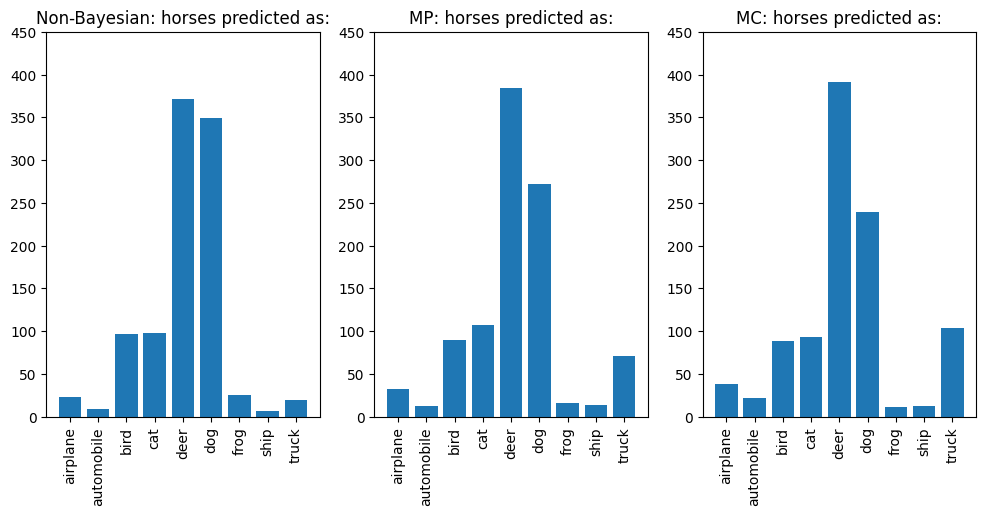

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.bar(np.unique(pred_labels[unknown_idx],return_counts=True)[0],np.unique(pred_labels[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=90)
plt.title("Non-Bayesian: horses predicted as:")
plt.ylim([0,450])


plt.subplot(1,3,2)
plt.bar(np.unique(pred_labels_mp[unknown_idx],return_counts=True)[0],np.unique(pred_labels_mp[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=90)
plt.title("MP: horses predicted as:")
plt.ylim([0,450])

plt.subplot(1,3,3)
plt.bar(np.unique(pred_labels_mc[unknown_idx],return_counts=True)[0],np.unique(pred_labels_mc[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=90)
plt.title("MC: horses predicted as:")
plt.ylim([0,450])



plt.show()

As you see in the plot barplot above, most of the horses were classified as deers, which kind of makes sense, because it is the most simlar class to horse. There are also a lot of classifications as dogs or cats.

## Compare the predictions for a known and unknown image
Let's compare the predictions of all three models, for a known and an unknown image. For the two bayesian neural network, you will predict the same image for 50 times and look at the predictive distribution. We clearly see that besides the normal network model (Non-Bayesian) and the MP model the predictions of MC dropout model is not deterministic. This is due to the fact that for each forward-pass (if training is set to True during prediction time) different nodes are randomly deleted based on the given dropout rate specified in the model and therefore the weights and the resulting predictions changes a bit.

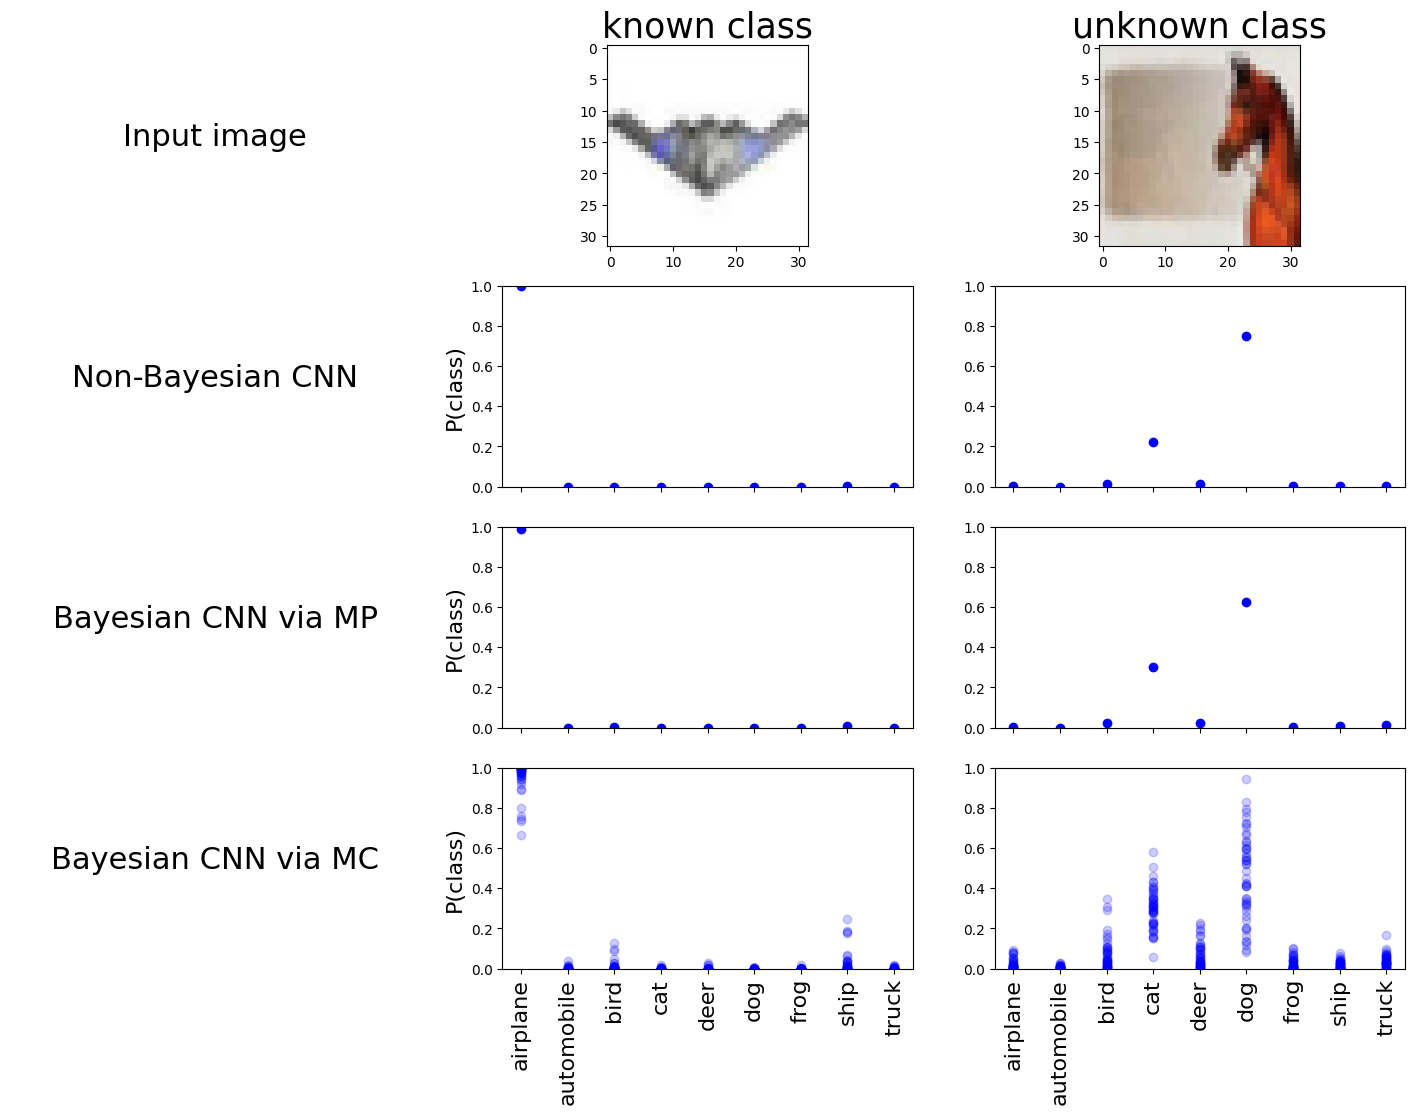

In [18]:
x_test_known = x_test[known_idx]
y_test_known = y_test[known_idx]

x_test_unknown = x_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

np.random.seed(7681)
random_sample_known=np.random.choice(range(0,len(x_test_known)),1)
np.random.seed(2384)
random_sample_unknown=np.random.choice(range(0,len(x_test_unknown)),1)

plt.figure(figsize=(18,12))
plt.subplot(4,3,1)
plt.axis('off')
plt.text(0.5,0.5, "Input image",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,2)
plt.imshow(np.squeeze(np.array(((((x_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
plt.title("known class",fontsize=25)
plt.subplot(4,3,3)
plt.imshow(np.squeeze(np.array(((((x_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
plt.title("unknown class",fontsize=25)

plt.subplot(4,3,4)
plt.axis('off')
plt.text(0.5,0.5, "Non-Bayesian CNN",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,5)
plt.scatter(range(0,9),model.predict(x_test_known[random_sample_known]),c="blue")
plt.ylabel("P(class)",fontsize=16)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.subplot(4,3,6)
plt.scatter(range(0,9),model.predict(x_test_unknown[random_sample_unknown]),c="blue")
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(4,3,7)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via MP",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,8)
plt.scatter(range(0,9),model_mp.model.predict(x_test_known[random_sample_known])[0],c="blue")
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,9)
plt.scatter(range(0,9),model_mp.model.predict(x_test_unknown[random_sample_unknown])[0],c="blue")
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])


plt.subplot(4,3,10)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via MC",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,11)
for i in range(0,50):
    plt.scatter(range(0,9),model([x_test_known[random_sample_known]],training=True),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,12)
for i in range(0,50):
    plt.scatter(range(0,9),model([x_test_unknown[random_sample_unknown]],training=True),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])


#plt.savefig("8.good2.pdf")
plt.show()

## Compare the uncertainty measures for all known and unknown classes
Let's compare the uncertainty measures for all images and all three models. Look at the distributions for the known and unknown class. Can you see a difference? You will look at the nll the total standard deviation and the entropy. Note that there is no total standard deviation for the non-bayesian network, because the prediction is always the same, even if you predict the same image for multiple times.

In [19]:
def plot_hists(dist, title, xlabel, xlim=None):
    plt.hist(dist[unknown_idx],bins=30, density=True,alpha = 0.7)
    plt.hist(dist[known_idx],bins=30,  density=True,alpha = 0.7)
    plt.title(title)
    plt.legend(['unknown','known'])
    plt.xlabel(xlabel)
    if xlim != None:
        plt.xlim(xlim)

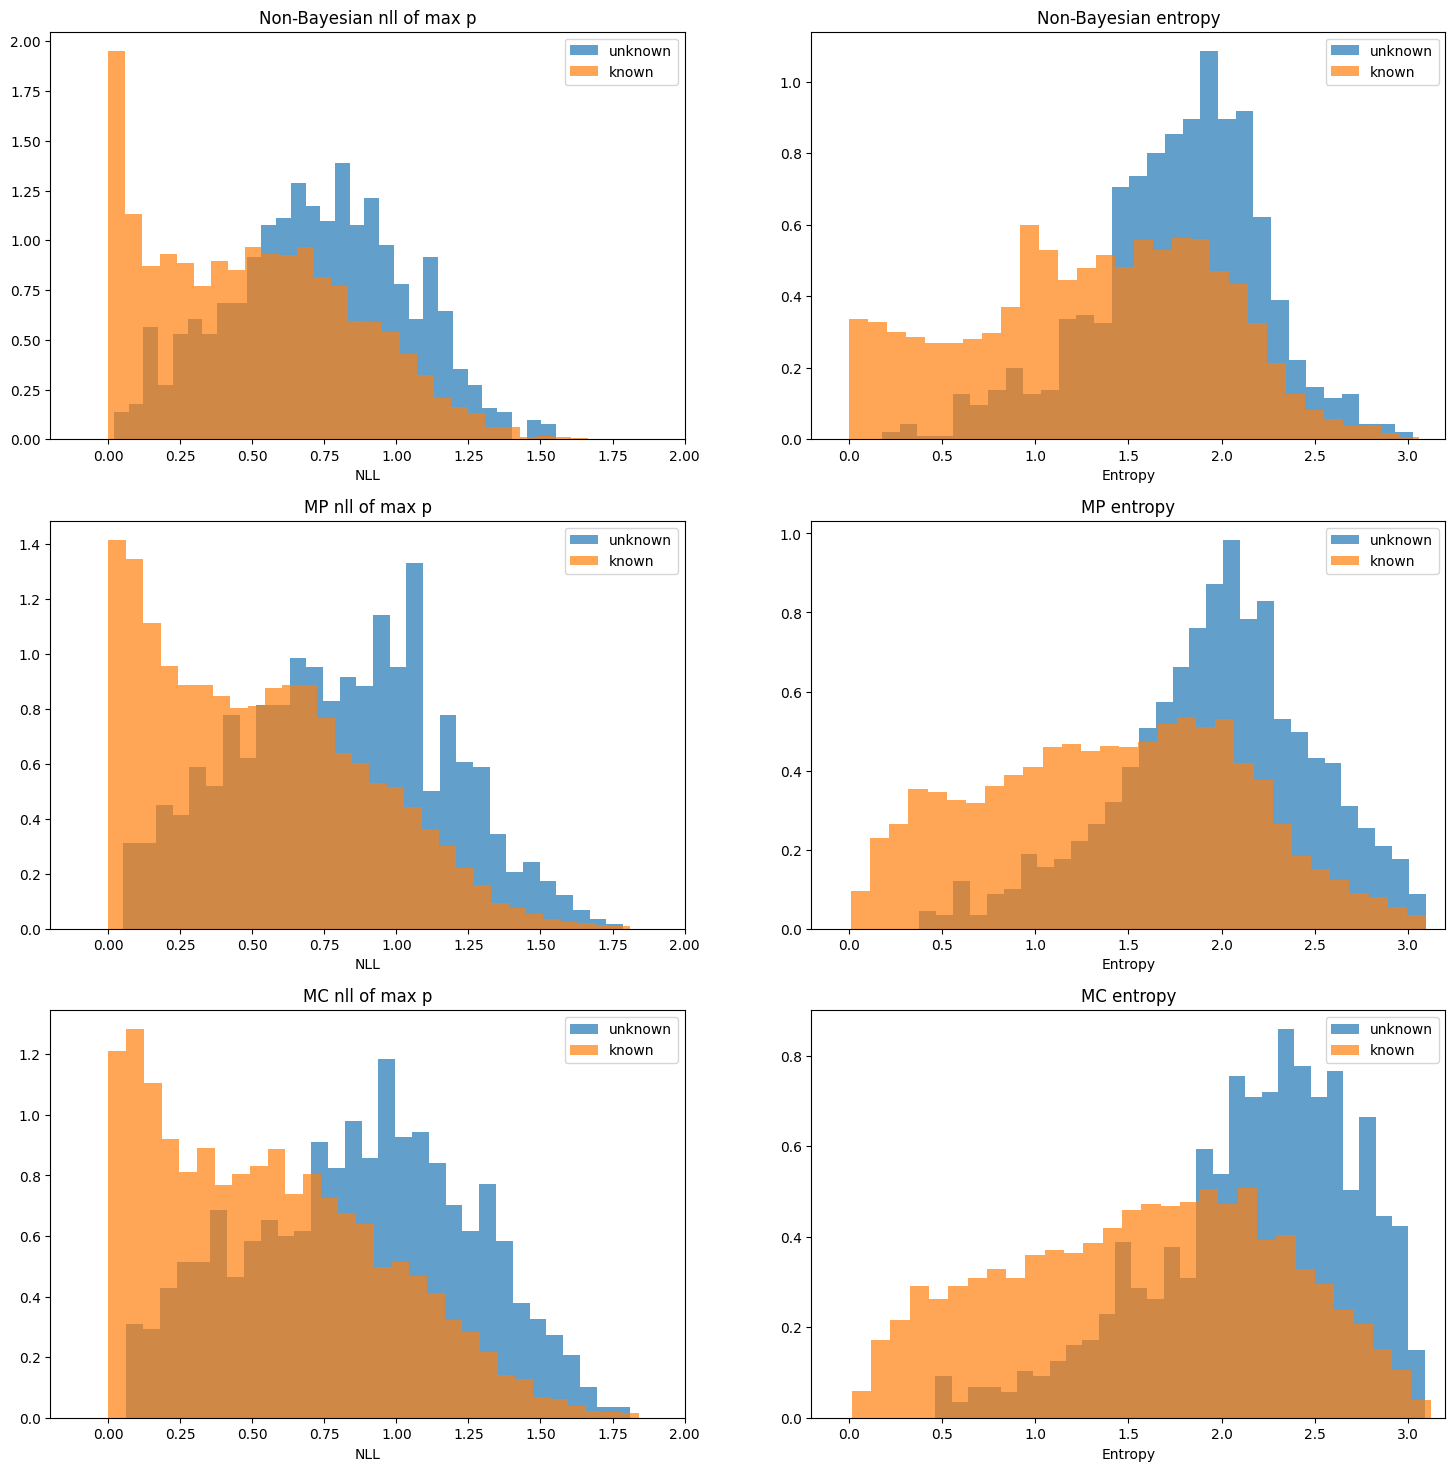

In [20]:
plt.figure(figsize=(18,18))

# Non-Bayesian
plt.subplot(3,2,1)
plot_hists(nll_, "Non-Bayesian nll of max p", "NLL", [-0.2,2])
plt.subplot(3,2,2)
plot_hists(entropy, "Non-Bayesian entropy", "Entropy", [-0.2,3.2])

# MP
plt.subplot(3,2,3)
plot_hists(nll_mp, "MP nll of max p", "NLL", [-0.2,2])
plt.subplot(3,2,4)
plot_hists(entropy_mp, "MP entropy", "Entropy", [-0.2,3.2])

# MC Methods
plt.subplot(3,2,5)
plot_hists(nll_mc, "MC nll of max p", "NLL", [-0.2,2])
plt.subplot(3,2,6)
plot_hists(entropy_mc, "MC entropy", "Entropy", [-0.2,3.2])

plt.show()

As you can see there is a clear difference in the uncertainty measures between the known and unknown classes. We have lower uncertainties in the known than in the unknown classes. You can also see that the bayesian models are showing higher uncertainties. Further if we looking at the histograms for MP and MC we see that they are very close to each other

# Use the uncertainty measures as filter
In the next cells you will use the uncertainty measures as filter. You will sort the predicitons by the uncertainty measures and calcualte the accuracy on the n most certrain images. You will compare all three models based on this accuracy vs most certain images plot. To simplify the the sorting and plotting, we first define a the function plot_certainty_idx_filter.

In [21]:
def plot_certainty_idx_filter(nr_of_best,certainty_measure,prediction,color,linetype):
    certainty_idx = np.argsort(certainty_measure.reshape(len(certainty_measure)))
    #acc_nbest = np.zeros((nr_of_best))
    acc_nbest = []
    for j in (range(0,nr_of_best)):
        acc_nbest.append(np.average(prediction[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]]))
    
    plt.plot(acc_nbest,c=color,linewidth=2,linestyle=linetype)
    plt.ylim([0.5,1.05])
    plt.ylabel('accuracy',fontsize=14)
    plt.xlabel('Number of Examples taken',fontsize=14)

C:\Users\kabr8509\Development\Miniconda3\envs\tensorflow_2.x\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\kabr8509\Development\Miniconda3\envs\tensorflow_2.x\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


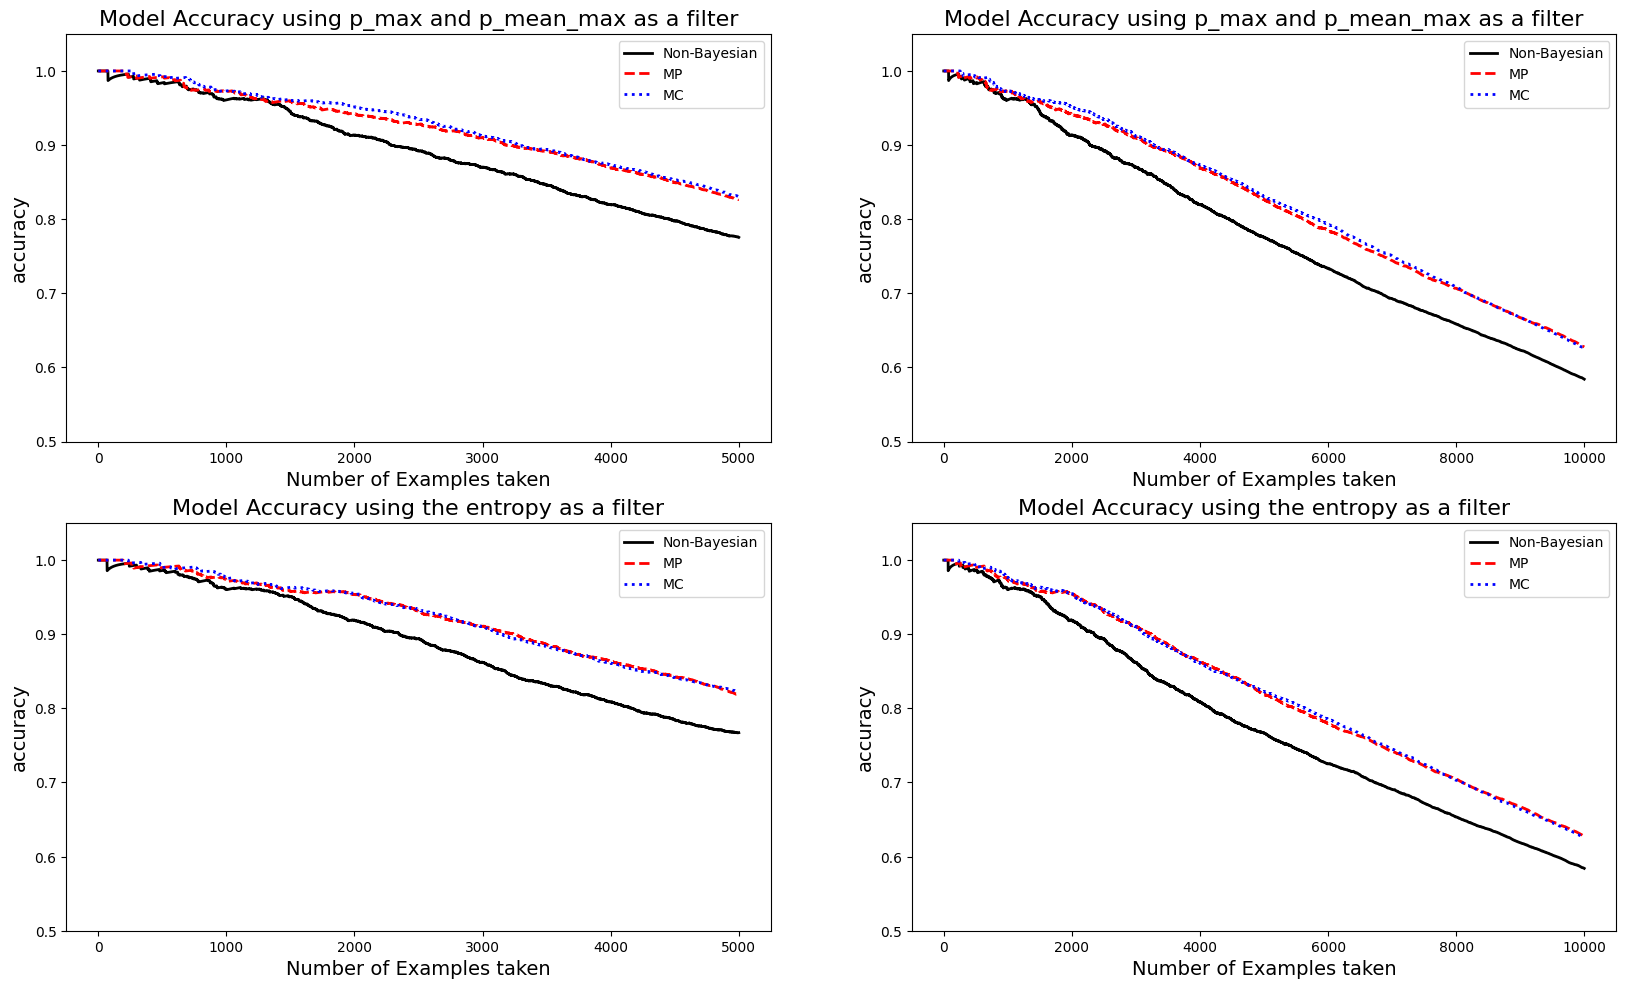

In [22]:
plt.figure(figsize=(20,18))
plt.subplot(3,2,1)
plot_certainty_idx_filter(5000,nll_,pred_labels,'black','solid')
plot_certainty_idx_filter(5000,nll_mp,pred_labels_mp,'red','dashed')
plot_certainty_idx_filter(5000,nll_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using p_max and p_mean_max as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'MP',"MC"], loc='upper right')

plt.subplot(3,2,2)
plot_certainty_idx_filter(10000,nll_,pred_labels,'black','solid')
plot_certainty_idx_filter(10000,nll_mp,pred_labels_mp,'red','dashed')
plot_certainty_idx_filter(10000,nll_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using p_max and p_mean_max as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'MP',"MC"], loc='upper right')

plt.subplot(3,2,3)
plot_certainty_idx_filter(5000,entropy,pred_labels,'black','solid')
plot_certainty_idx_filter(5000,entropy_mp,pred_labels_mp,'red','dashed')
plot_certainty_idx_filter(5000,entropy_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using the entropy as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'MP',"MC"], loc='upper right')

plt.subplot(3,2,4)
plot_certainty_idx_filter(10000,entropy,pred_labels,'black','solid')
plot_certainty_idx_filter(10000,entropy_mp,pred_labels_mp,'red','dashed')
plot_certainty_idx_filter(10000,entropy_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using the entropy as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'MP',"MC"], loc='upper right')


#plt.savefig("8.filter.pdf")
plt.show()

You see that both bayesian models outperform the non-bayesian model. This means the bayesian model are more appropriate when you want to have an uncertainty measures. Note that the approximation for the MC model is pretty close in this case only using one forward-pass instead of 50.

# ROC-Analysis to destinguish between novel class

In the following we, present an ROC analysic for the ability to detect out of distribution (OOD) examples. We, use the entropy to destinguish between in distribution (IND) from OOD exaples. 

[1] Dan Hendrycks and Kevin Gimpel. A baseline for detecting misclassified and out-of-distribution
examples in neural networks. arXiv:1610.02136

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def roc_curve_analysis(certainty_score):
    in_class = y_test[known_idx]
    out_class_idx = [l not in in_class for l in y_test]
    fpr, tpr, _ = roc_curve(out_class_idx, certainty_score)
    auroc = roc_auc_score(out_class_idx, certainty_score)
    print(auroc)
    return (fpr, tpr, auroc)

0.7095340000000001
0.7384458888888888
0.7349944444444445
0.6911361666666667
0.7141252222222222
0.7092809444444443


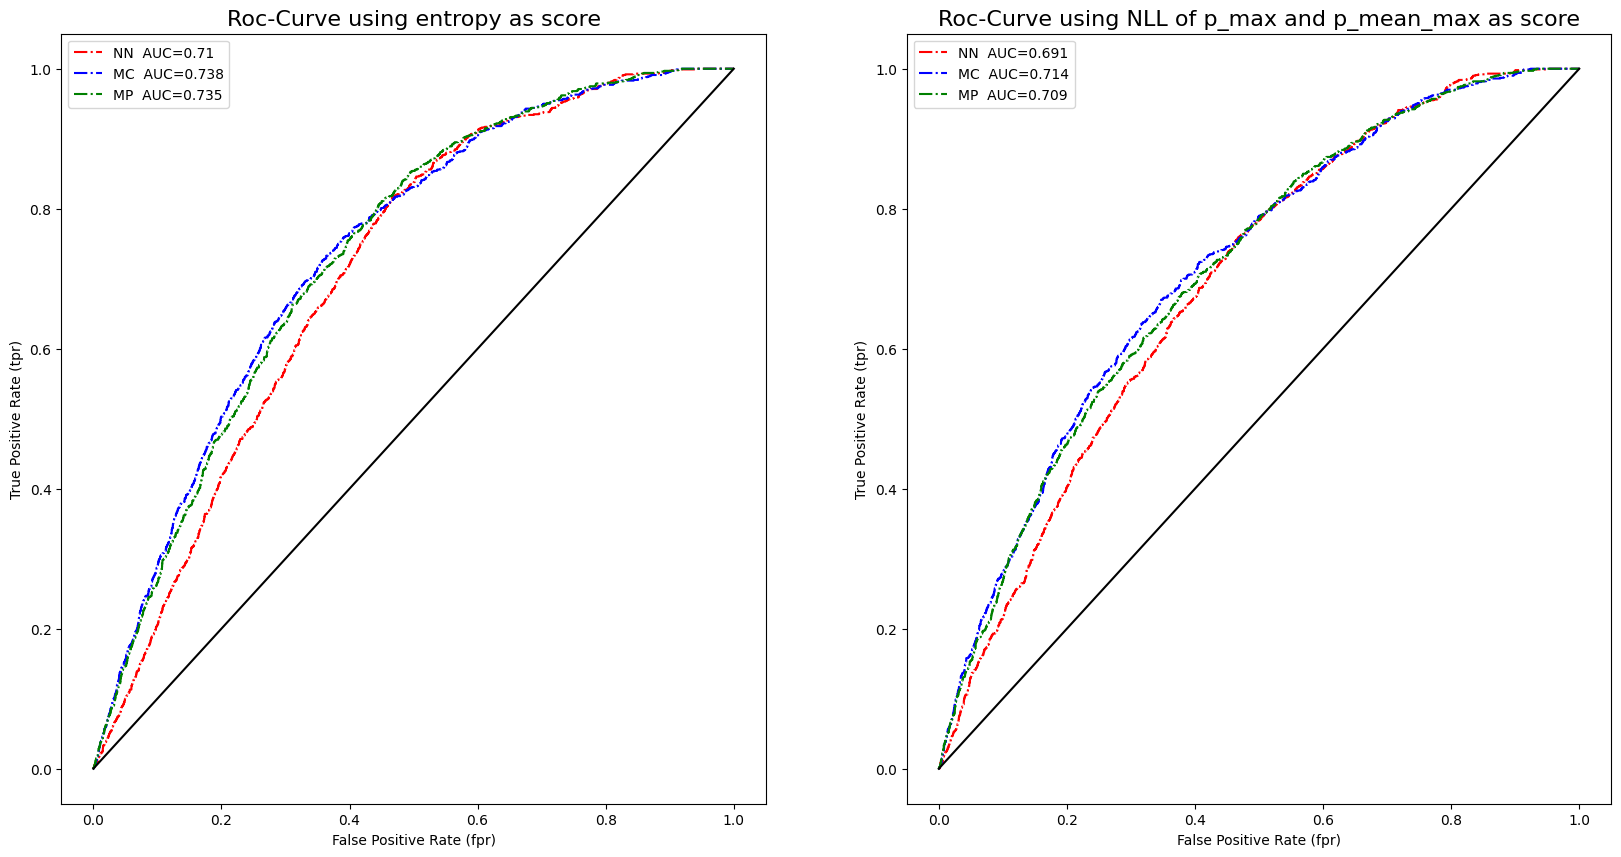

In [24]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
fpr, tpr, auroc = roc_curve_analysis(entropy)
plt.plot(fpr, tpr, '-.r', label='NN  AUC={}'.format(round(auroc,3)))

fpr, tpr, auroc = roc_curve_analysis(entropy_mc)
plt.plot(fpr, tpr, '-.b', label='MC  AUC={}'.format(round(auroc,3)))

fpr, tpr, auroc = roc_curve_analysis(entropy_mp)
plt.plot(fpr, tpr, '-.g', label='MP  AUC={}'.format(round(auroc,3)))

plt.plot([0,1],color="black")
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.title('Roc-Curve using entropy as score',fontsize=16)
plt.legend()

plt.subplot(1,2,2)
fpr, tpr, auroc = roc_curve_analysis(nll_)
plt.plot(fpr, tpr, '-.r', label='NN  AUC={}'.format(round(auroc,3)))

fpr, tpr, auroc = roc_curve_analysis(nll_mc)
plt.plot(fpr, tpr, '-.b', label='MC  AUC={}'.format(round(auroc,3)))

fpr, tpr, auroc = roc_curve_analysis(nll_mp)
plt.plot(fpr, tpr, '-.g', label='MP  AUC={}'.format(round(auroc,3)))

plt.plot([0,1],color="black")
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.title('Roc-Curve using NLL of p_max and p_mean_max as score',fontsize=16)
plt.legend()
plt.show()